In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras

import orchard as oc
import importlib
import pickle

importlib.reload(oc)

ModuleNotFoundError: No module named 'distutils'

In [2]:
steps, horizon, features, learning_rate = oc.get_params()

In [10]:
df = oc.unpickle_data()

In [4]:
ws = pd.read_csv("weather_station_05_05_24.csv")
ws.set_index("ob_time", inplace=True)
ws.drop(["id", "remote_id", "air_quality", "wind_gust_speed"], axis=1, inplace=True)
ws.index = pd.to_datetime(ws.index)
ws.replace("\\N", np.nan, inplace=True)
ws["ground_temperature"] = pd.to_numeric(ws["ground_temperature"])
ws.rename(
    {
        "ambient_temperature": "air_temperature",
        "ground_temperature": "q10cm_soil_temp",
        "air_pressure": "msl_pressure",
        "humidity": "rltv_hum",
        "rainfall": "prcp_amt",
    },
    axis=1,
    inplace=True,
)
ws.dropna(inplace=True)
# Using heathrow as a template
ws = ws.reindex(df["greater-london"]["00708_heathrow"].columns, axis=1)

ws_data = oc.build_station_dataset(ws)

2024-05-05 21:05:46.240775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5554 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:26:00.0, compute capability: 8.6


In [5]:
ds = oc.build_dataset(df, steps=steps, horizon=horizon)

  2%|1         | 2/102 [00:02<01:55,  1.16s/it]

In [4]:
m, h = oc.run_model(ds, 2, steps, horizon, features, learning_rate)

In [6]:
model = keras.models.load_model("model.keras")

In [7]:
with open("model-hist.pkl", "rb") as f:
    history = pickle.load(f)

In [8]:
preds = model.predict(ws_data)
preds = oc.inverse_min_max_scale(preds.reshape(-1, 12))

I0000 00:00:1714939714.600808  643807 service.cc:145] XLA service 0x7efc9c005490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714939714.600841  643807 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-05 21:08:34.619124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-05 21:08:34.726878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


      5/Unknown 2s 15ms/step

I0000 00:00:1714939715.942536  643807 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1714939716.595101  646069 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_421', 12 bytes spill stores, 12 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step


2024-05-05 21:08:37.206951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/sam/miniconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [11]:
preds = pd.DataFrame(preds).rename(
    {i: v for i, v in enumerate(df["greater-london"]["00708_heathrow"].columns)}, axis=1
)

In [13]:
preds

,wind_direction,wind_speed,msl_pressure,air_temperature,rltv_hum,prcp_amt,q10cm_soil_temp,7,8,9,10,11
0,147.598358,27.099962,1002.536743,9.358970,58.874374,4.558279,14.322002,0.431314,10.112719,13.924548,5.718246,2015.982300
1,150.233246,26.746599,1000.858276,9.135987,58.454990,4.640740,14.509536,0.445848,10.371317,14.504462,6.056806,2016.247803
2,151.389313,27.740942,1003.561279,9.851267,60.101315,4.741766,14.875090,0.453785,10.594161,14.584659,5.975589,2016.151855
3,159.130371,28.256359,1003.095276,9.953615,60.385761,4.917437,15.377058,0.471841,10.984317,15.297280,6.366114,2016.447266
4,174.841583,32.119640,1009.153198,11.848878,64.655037,5.363936,16.793474,0.509486,11.705148,16.015907,6.478028,2016.459717
...,...,...,...,...,...,...,...,...,...,...,...,...
3231,235.495148,41.021214,1020.745483,15.939187,73.663719,6.877132,21.395954,0.651578,14.978581,20.290174,8.185390,2017.623779
3232,152.913849,28.199055,1004.270569,10.130008,60.811325,4.847184,15.180410,0.464564,10.813495,14.850080,6.068029,2016.203125
3233,161.067749,28.634239,1003.588928,10.124517,60.808479,4.976761,15.561032,0.477220,11.107643,15.449863,6.433063,2016.491943
3234,108.691780,19.461376,992.540894,5.620829,50.202049,3.345695,10.630088,0.314158,7.715415,10.813956,4.593719,2015.282227


In [14]:
ws

,wind_direction,wind_speed,msl_pressure,air_temperature,rltv_hum,prcp_amt,q10cm_soil_temp
ob_time,,,,,,,
2023-09-30 18:43:39,29.99,8.47,1006.80,16.24,73.22,0.0,14.13
2023-09-30 18:48:41,35.53,7.86,1006.80,16.22,74.63,0.0,14.13
2023-09-30 18:53:43,33.67,6.96,1006.79,16.20,75.21,0.0,14.13
2023-09-30 18:58:45,24.92,6.69,1006.75,16.17,75.07,0.0,14.13
2023-09-30 19:03:47,35.20,6.64,1006.81,16.16,75.30,0.0,14.13
...,...,...,...,...,...,...,...
2024-05-05 18:05:04,45.14,4.41,991.44,19.16,50.95,0.0,11.19
2024-05-05 18:10:05,42.01,4.01,991.43,19.15,51.35,0.0,11.19
2024-05-05 18:15:07,45.53,4.18,991.42,19.13,51.37,0.0,11.19


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


2024-05-05 21:22:51.769842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/sam/miniconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: cannot reshape array of size 14 into shape (12)

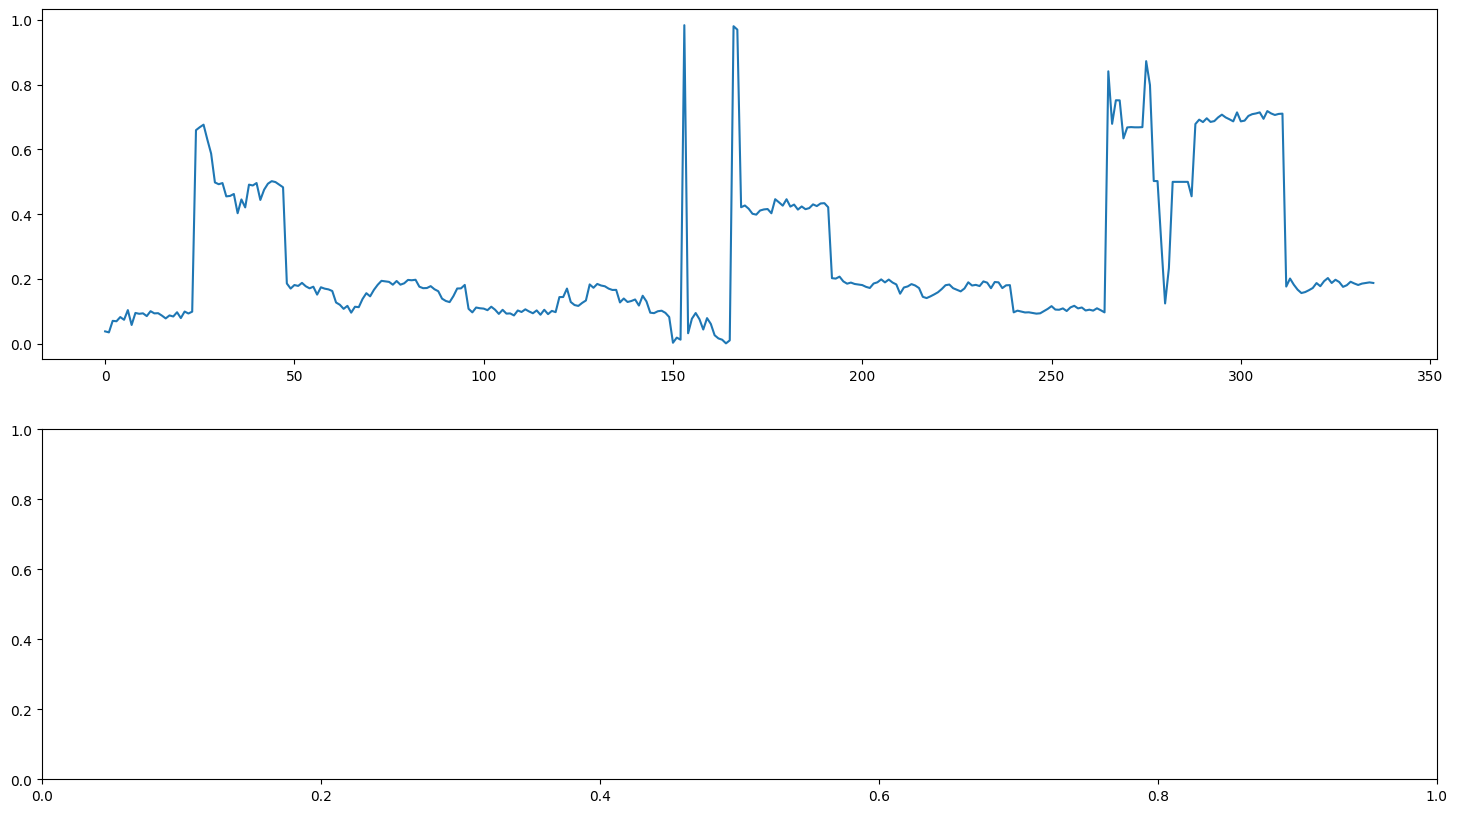

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(18, 10))
days = 14

model_configs = {0: {"test_ds": ws_data, "model": model}}

vline = np.linspace(0, days * 24, days + 1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val["test_ds"]
    preds = val["model"].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(oc.inverse_min_max_scale(preds.reshape(-1, 12))[:, 3])
    ax.set_title(key)
    ax.vlines(
        vline, ymin=0, ymax=1, linestyle="dotted", transform=ax.get_xaxis_transform()
    )
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print("First Two Weeks of Predictions")